# Dataset Sufficiency Analysis for Classification Tutorial


## _Problem Statement_

For machine learning tasks, often we would like to evaluate the performance of a model on a small, preliminary dataset. In situations where data collection is expensive, we would like to extrapolate hypothetical performance out to a larger dataset.

DAML has introduced a method projecting performance via _sufficiency curves_.


### _When to use_

The `Sufficiency` class should be used when you would like to extrapolate hypothetical performance. For example, if you have a small dataset, and would like to know if it is worthwhile to collect more data.


### _What you will need_

1. A particular model architecture.
2. Metric(s) that we would like to evaluate.
3. A dataset of interest.


### _Setting up_

Let's import the required libraries needed to set up a minimal working example


In [1]:
try:
    import google.colab  # noqa: F401

    !pip install -q daml[torch] torchmetrics torchvision
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

!pip install -q tabulate

import os

from pytest import approx

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from typing import Dict, Sequence, cast

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision.datasets as datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, Dataset, Subset

from daml.metrics import Sufficiency

np.random.seed(0)
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.manual_seed(0)
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True

In [3]:
datasets.MNIST("./data", train=True, download=True)
datasets.MNIST("./data", train=False, download=True)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

## Load data and define functions


Load the MNIST data and create the training and test datasets.


In [4]:
# Download the mnist dataset and preview the images
to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=to_tensor)
test_ds = datasets.MNIST("./data", train=False, download=True, transform=to_tensor)

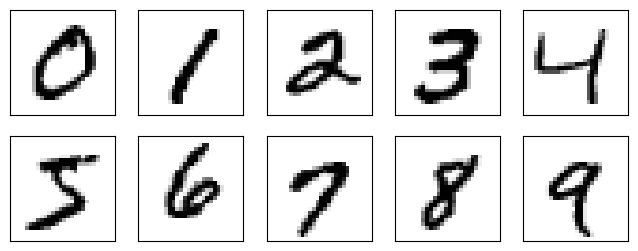

In [5]:
fig = plt.figure(figsize=(8, 3))

for lbl in range(10):
    i = (train_ds.targets == lbl).nonzero()[0][0]
    img = train_ds.data[i]
    ax = fig.add_subplot(2, 5, lbl + 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img, cmap="gray_r")

For the purposes of this example, we will use subsets of the training (2000) and test (500) data.


In [6]:
# Take a subset of 2000 training images and 500 test images
train_ds = Subset(train_ds, range(2000))
test_ds = Subset(test_ds, range(500))

Next, we define the network architecture we will be using.


In [7]:
# Define our network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Compile the model
model = torch.compile(Net().to(device))

# Type cast the model back to Net as torch.compile returns a Unknown
# Nothing internally changes from the cast; we are simply signaling the type
model = cast(Net, model)

Finally, we define our custom training and evaluation functions. Sufficiency requires that the evaluation function returns a dictionary of the results.


In [8]:
def custom_train(model: nn.Module, dataset: Dataset, indices: Sequence[int]):
    # Defined only for this testing scenario
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epochs = 10

    # Define the dataloader for training
    dataloader = DataLoader(Subset(dataset, indices), batch_size=16)

    for epoch in range(epochs):
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load targets/labels to device
            y = torch.Tensor(batch[1]).to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(X)
            # Compute loss
            loss = criterion(outputs, y)
            # Back prop
            loss.backward()
            # Update weights/parameters
            optimizer.step()

In [9]:
def custom_eval(model: nn.Module, dataset: Dataset) -> Dict[str, float]:
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    result = 0

    # Set model layers into evaluation mode
    model.eval()
    dataloader = DataLoader(dataset, batch_size=16)
    # Tell PyTorch to not track gradients, greatly speeds up processing
    with torch.no_grad():
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load targets/labels to device
            y = torch.Tensor(batch[1]).to(device)
            preds = model(X)
            metric.update(preds, y)
        result = metric.compute()
    return {"Accuracy": result}

## Initialize sufficiency metric

Attach the custom training and evaluation functions to the Sufficiency metric and define the number of models to train in parallel (stability), as well as the number of steps along the learning curve to evaluate.


In [10]:
# Instantiate sufficiency metric
suff = Sufficiency(
    model=model,
    train_ds=train_ds,
    test_ds=test_ds,
    train_fn=custom_train,
    eval_fn=custom_eval,
    runs=5,
    substeps=10,
)

## Evaluate Sufficiency

Now we can evaluate the metric to train the models and produce the learning curve.


In [11]:
# Train & test model
output = suff.evaluate()

[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT forward /tmp/ipykernel_231033/1712871160.py line 11 
[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING] due to: 
[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING]   File "/home/daml/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/_inductor/scheduler.py", line 1630, in create_backend
[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING]     raise RuntimeError(
[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING] torch._dynamo.exc.BackendCompilerFailed: backend='inductor' raised:
[2024-05-21 19:07:31,992] torch._dynamo.convert_frame: [WARNING] RuntimeError: Found Quadro P2000 with Max-Q Design which is too old to be supported by the triton GPU compiler, which is used as the backend. Triton only supports devices of CUDA Capability >= 7.0, but your devi

In [12]:
# Print out sufficiency output in a table format
from tabulate import tabulate

print(tabulate(output, headers=list(output.keys()), tablefmt="pretty"))

+---------+---------------------+
| _STEPS_ |      Accuracy       |
+---------+---------------------+
|   20    | 0.11640000343322754 |
|   33    | 0.28439998626708984 |
|   55    | 0.3868000030517578  |
|   92    | 0.6435999870300293  |
|   154   | 0.7527999877929688  |
|   258   | 0.8059999465942382  |
|   430   | 0.8524000167846679  |
|   718   | 0.8828000068664551  |
|  1198   | 0.9144000053405762  |
|  2000   | 0.9272000312805175  |
+---------+---------------------+


In [13]:
# Print out projected output values
projection = Sufficiency.project(output, [1000, 2000, 4000], 100)
print(tabulate(projection, list(projection.keys()), tablefmt="pretty"))

+---------+--------------------+
| _STEPS_ |      Accuracy      |
+---------+--------------------+
|  1000   | 0.9113676734554496 |
|  2000   | 0.9485284513812341 |
|  4000   | 0.9743643981590533 |
+---------+--------------------+


In [14]:
### TEST ASSERTION ###
print(output["Accuracy"][-1])
print(projection["Accuracy"][-1])
assert output["Accuracy"][-1] == approx(0.93, abs=0.03)
assert projection["Accuracy"][-1] == approx(0.95, abs=0.03)

0.9272000312805175
0.9743643981590533


/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in power
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/home/daml/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in power
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in square
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in square
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/home/daml/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered i

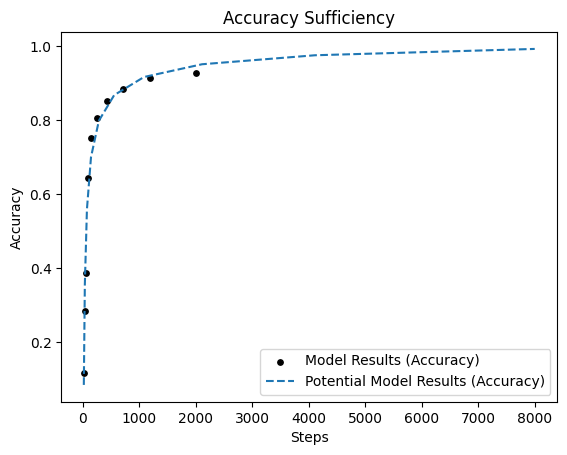

In [15]:
# Plot the output using the convenience function
_ = Sufficiency.plot(output)

## Results

Using this learning curve, we can project performance under much larger datasets (with the same model).


Use the learning curve to predict the amount of training samples required to achieve a desired accuracy.

In the following cells, predict how many training images are
needed to achieve model accuracies of 50%, 90%, and 98%.


In [16]:
# Initialize the array of desired accuracies
desired_accuracies = np.array([0.5, 0.9, 0.98])

# Evaluate the learning curve to infer the needed amount of training data
num_needed_samples = Sufficiency.inv_project(desired_accuracies, output)

/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in power
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/home/daml/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in power
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in square
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/workspaces/daml/src/daml/_internal/metrics/sufficiency.py:95: RuntimeWarning: overflow encountered in power
  inner = np.sum(np.square(p_i - x[0] * n_i ** (-x[1]) - x[2]))
/home/daml/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in

In [17]:
# Print the amount of needed data needed to achieve the accuracies of interest
for i, accuracy in enumerate(desired_accuracies):
    print(
        f"To achieve {accuracy*100} % accuracy, {num_needed_samples[i]} training samples are needed."
    )

To achieve 50.0 % accuracy, 60 training samples are needed.
To achieve 90.0 % accuracy, 844 training samples are needed.
To achieve 98.0 % accuracy, 4845 training samples are needed.
